In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
#from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import ParameterGrid
#from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric, plot, plot_components,add_changepoints_to_plot

In [16]:
dataset = pd.read_csv("data.csv")

In [18]:
# change data type of ds column to pd.datatime as require of model Prophet
dataset['ds'] = pd.to_datetime(dataset['ds'], format='%d/%m/%Y')

# Splitting the data into train and test sets
train = dataset.iloc[:-4]  # Using all except the last 4 months for training
test = dataset.iloc[-4:]  # Using the last 4 months for testing

In [4]:
# using simple MAPE to find the best hyperparameter
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Parameters that can be tuned

**changepoint_prior_scale**: This is probably the most impactful parameter. It determines the flexibility of the trend, and in particular how much the trend changes at the trend changepoints. As described in this documentation, if it is too small, the trend will be underfit and variance that should have been modeled with trend changes will instead end up being handled with the noise term. If it is too large, the trend will overfit and in the most extreme case you can end up with the trend capturing yearly seasonality. The default of 0.05 works for many time series, but this could be tuned; a range of [0.001, 0.5] would likely be about right. Parameters like this (regularization penalties; this is effectively a lasso penalty) are often tuned on a log scale.

**seasonality_prior_scale**: This parameter controls the flexibility of the seasonality. Similarly, a large value allows the seasonality to fit large fluctuations, a small value shrinks the magnitude of the seasonality. The default is 10., which applies basically no regularization. That is because we very rarely see overfitting here (there’s inherent regularization with the fact that it is being modeled with a truncated Fourier series, so it’s essentially low-pass filtered). A reasonable range for tuning it would probably be [0.01, 10]; when set to 0.01 you should find that the magnitude of seasonality is forced to be very small. This likely also makes sense on a log scale, since it is effectively an L2 penalty like in ridge regression.

**holidays_prior_scale**: This controls flexibility to fit holiday effects. Similar to seasonality_prior_scale, it defaults to 10.0 which applies basically no regularization, since we usually have multiple observations of holidays and can do a good job of estimating their effects. This could also be tuned on a range of [0.01, 10] as with seasonality_prior_scale.

**seasonality_mode**: Options are ['additive', 'multiplicative']. Default is 'additive', but many business time series will have multiplicative seasonality. This is best identified just from looking at the time series and seeing if the magnitude of seasonal fluctuations grows with the magnitude of the time series (see the documentation here on multiplicative seasonality), but when that isn’t possible, it could be tuned.

In [5]:
# input hyperparameter want to try
params_grid = {'seasonality_mode':('multiplicative','additive'),
            'changepoint_prior_scale':[0.001, 0.002, 0.003, 0.004, 0.005,
                                        0.01, 0.02, 0.03, 0.04, 0.05,
                                        0.1,0.2, 0.3, 0.4, 0.5],
            'seasonality_prior_scale':[0.01, 0.02, 0.03, 0.04, 0.05,
                                        0.1,0.2, 0.3, 0.4, 0.5,
                                        1.0, 2.0, 3.0, 4.0, 5.0, 10.0]}

# make parameters grid to test
grid = ParameterGrid(params_grid)

# trial numbers
cnt = 0
for p in grid:
    cnt = cnt+1
print('Total Possible Models',cnt)

Total Possible Models 480


In [6]:
# create initial DataFrame
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])

#trial count
_try = 0

# try hyperparameters
for p in grid:
    train_forecast = pd.DataFrame()
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                        seasonality_prior_scale = p['seasonality_prior_scale'],
                        seasonality_mode = p['seasonality_mode'])
    train_model.fit(train)
    train_forecast = train_model.make_future_dataframe(periods=12, freq='MS')
    train_forecast = train_model.predict(train_forecast)
    train_forecast = train_forecast[['ds','yhat']]
    train_forecast = train_forecast[35:39]
    train_test = test
    MAPE = mean_absolute_percentage_error(train_test['y'],abs(train_forecast['yhat']))
    _try +=1
    print('--------------------------------------------------------------------------------------------------')
    print('try', _try, '-- Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    try_parameter = pd.DataFrame({'MAPE':MAPE,'Parameters':[p]})
    model_parameters = pd.concat([model_parameters,try_parameter],ignore_index=True)

16:58:52 - cmdstanpy - INFO - Chain [1] start processing
16:58:53 - cmdstanpy - INFO - Chain [1] done processing
16:58:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 1 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 36.794634606096835


16:58:53 - cmdstanpy - INFO - Chain [1] done processing
16:58:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 2 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 38.677337672344855


16:58:53 - cmdstanpy - INFO - Chain [1] done processing
16:58:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 3 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 38.38883774814511


16:58:54 - cmdstanpy - INFO - Chain [1] done processing
16:58:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 4 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 35.57543512979981


16:58:54 - cmdstanpy - INFO - Chain [1] done processing
16:58:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 5 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 28.060628988219243


16:58:55 - cmdstanpy - INFO - Chain [1] done processing
16:58:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 6 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.366799332829915


16:58:56 - cmdstanpy - INFO - Chain [1] done processing
16:58:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 7 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.86839115864802


16:58:59 - cmdstanpy - INFO - Chain [1] done processing
16:58:59 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 8 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 6.998663780384804


16:59:02 - cmdstanpy - INFO - Chain [1] done processing
16:59:03 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 9 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.572918944800678


16:59:04 - cmdstanpy - INFO - Chain [1] done processing
16:59:04 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 10 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.744618968286758


16:59:06 - cmdstanpy - INFO - Chain [1] done processing
16:59:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 11 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.095216981701402


16:59:06 - cmdstanpy - INFO - Chain [1] done processing
16:59:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 12 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 42.46423563845325


16:59:07 - cmdstanpy - INFO - Chain [1] done processing
16:59:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 13 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 47.49037633751559


16:59:08 - cmdstanpy - INFO - Chain [1] done processing
16:59:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 14 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 27.26461435521822


16:59:09 - cmdstanpy - INFO - Chain [1] done processing
16:59:09 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 15 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.91330620799316


16:59:13 - cmdstanpy - INFO - Chain [1] done processing
16:59:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 16 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 52.57095920272755


16:59:14 - cmdstanpy - INFO - Chain [1] done processing
16:59:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 17 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.770352344388


16:59:16 - cmdstanpy - INFO - Chain [1] done processing
16:59:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 18 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 28.907484443784632


16:59:16 - cmdstanpy - INFO - Chain [1] done processing
16:59:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 19 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 28.100490854085976


16:59:17 - cmdstanpy - INFO - Chain [1] done processing
16:59:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 20 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.8893196475081


16:59:17 - cmdstanpy - INFO - Chain [1] done processing
16:59:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 21 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.77223202890745


16:59:18 - cmdstanpy - INFO - Chain [1] done processing
16:59:18 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 22 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.32336233652297


16:59:19 - cmdstanpy - INFO - Chain [1] done processing
16:59:19 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 23 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 6.2137385285376014


16:59:19 - cmdstanpy - INFO - Chain [1] done processing
16:59:19 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 24 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.341235563717378


16:59:19 - cmdstanpy - INFO - Chain [1] done processing
16:59:20 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 25 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 6.455744293870086


16:59:20 - cmdstanpy - INFO - Chain [1] done processing
16:59:20 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 26 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.22977896861019


16:59:21 - cmdstanpy - INFO - Chain [1] done processing
16:59:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 27 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.966646273656487


16:59:21 - cmdstanpy - INFO - Chain [1] done processing
16:59:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 28 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.867096379459966


16:59:21 - cmdstanpy - INFO - Chain [1] done processing
16:59:22 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 29 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 42.53128293910321


16:59:22 - cmdstanpy - INFO - Chain [1] done processing
16:59:22 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 30 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 54.553360300326595


16:59:22 - cmdstanpy - INFO - Chain [1] done processing
16:59:22 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 31 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 54.32056172042961


16:59:23 - cmdstanpy - INFO - Chain [1] done processing
16:59:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 32 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 298.84370689829547


16:59:24 - cmdstanpy - INFO - Chain [1] done processing
16:59:24 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 33 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 36.83082552097465


16:59:27 - cmdstanpy - INFO - Chain [1] done processing
16:59:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 34 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 38.06744783016146


16:59:27 - cmdstanpy - INFO - Chain [1] done processing
16:59:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 35 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 38.2740410982735


16:59:28 - cmdstanpy - INFO - Chain [1] done processing
16:59:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 36 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 35.34952152049273


16:59:28 - cmdstanpy - INFO - Chain [1] done processing
16:59:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 37 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 27.912809894220647


16:59:29 - cmdstanpy - INFO - Chain [1] done processing
16:59:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 38 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.395299673661597


16:59:30 - cmdstanpy - INFO - Chain [1] done processing
16:59:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 39 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 36.631707538096784


16:59:31 - cmdstanpy - INFO - Chain [1] done processing
16:59:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 40 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 48.71694630726541


17:00:01 - cmdstanpy - INFO - Chain [1] done processing
17:00:02 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 41 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.690916587081137


17:00:04 - cmdstanpy - INFO - Chain [1] done processing
17:00:04 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 42 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.539987175599155


17:00:05 - cmdstanpy - INFO - Chain [1] done processing
17:00:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 43 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 27.60171203938409


17:00:06 - cmdstanpy - INFO - Chain [1] done processing
17:00:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 44 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 42.30674888215021


17:00:06 - cmdstanpy - INFO - Chain [1] done processing
17:00:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 45 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 47.3058304667073


17:00:07 - cmdstanpy - INFO - Chain [1] done processing
17:00:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 46 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 46.37430959203639


17:00:08 - cmdstanpy - INFO - Chain [1] done processing
17:00:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 47 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 53.509554854352224


17:00:20 - cmdstanpy - INFO - Chain [1] done processing
17:00:20 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 48 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 72.0846244442595


17:00:22 - cmdstanpy - INFO - Chain [1] done processing
17:00:22 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 49 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.966970572755127


17:00:25 - cmdstanpy - INFO - Chain [1] done processing
17:00:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 50 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.036205280856052


17:00:25 - cmdstanpy - INFO - Chain [1] done processing
17:00:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 51 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 28.061777047980097


17:00:26 - cmdstanpy - INFO - Chain [1] done processing
17:00:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 52 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.937999598936106


17:00:26 - cmdstanpy - INFO - Chain [1] done processing
17:00:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 53 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.803372489343737


17:00:27 - cmdstanpy - INFO - Chain [1] done processing
17:00:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 54 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.46988059083376


17:00:27 - cmdstanpy - INFO - Chain [1] done processing
17:00:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 55 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 6.004605610879668


17:00:27 - cmdstanpy - INFO - Chain [1] done processing
17:00:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 56 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 5.9687201037388515


17:00:28 - cmdstanpy - INFO - Chain [1] done processing
17:00:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 57 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 6.448969840490052


17:00:28 - cmdstanpy - INFO - Chain [1] done processing
17:00:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 58 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.701923956970349


17:00:29 - cmdstanpy - INFO - Chain [1] done processing
17:00:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 59 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.696649267482066


17:00:29 - cmdstanpy - INFO - Chain [1] done processing
17:00:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 60 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 21.655285258072183


17:00:30 - cmdstanpy - INFO - Chain [1] done processing
17:00:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 61 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 42.953670027302124


17:00:30 - cmdstanpy - INFO - Chain [1] done processing
17:00:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 62 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 54.58116441783154


17:00:31 - cmdstanpy - INFO - Chain [1] done processing
17:00:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 63 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 54.36171894649229


17:00:31 - cmdstanpy - INFO - Chain [1] done processing
17:00:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 64 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 300.4433638098008


17:00:32 - cmdstanpy - INFO - Chain [1] done processing
17:00:32 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 65 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 36.85006517740009


17:00:34 - cmdstanpy - INFO - Chain [1] done processing
17:00:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 66 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 38.234488772933304


17:00:34 - cmdstanpy - INFO - Chain [1] done processing
17:00:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 67 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 37.85893258711797


17:00:35 - cmdstanpy - INFO - Chain [1] done processing
17:00:35 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 68 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.947971073103236


17:00:35 - cmdstanpy - INFO - Chain [1] done processing
17:00:35 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 69 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 27.11265765230847


17:00:36 - cmdstanpy - INFO - Chain [1] done processing
17:00:36 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 70 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.950229252623094


17:00:36 - cmdstanpy - INFO - Chain [1] done processing
17:00:37 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 71 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 24.560592327057858


17:00:38 - cmdstanpy - INFO - Chain [1] done processing
17:00:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 72 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.66321148646497


17:00:38 - cmdstanpy - INFO - Chain [1] done processing
17:00:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 73 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 21.230327169193824


17:00:38 - cmdstanpy - INFO - Chain [1] done processing
17:00:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 74 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.568260031395178


17:00:39 - cmdstanpy - INFO - Chain [1] done processing
17:00:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 75 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.13535747149709


17:00:39 - cmdstanpy - INFO - Chain [1] done processing
17:00:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 76 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 42.043564388690605


17:00:40 - cmdstanpy - INFO - Chain [1] done processing
17:00:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 77 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 46.755912083285345


17:00:40 - cmdstanpy - INFO - Chain [1] done processing
17:00:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 78 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 45.93444941065054


17:00:41 - cmdstanpy - INFO - Chain [1] done processing
17:00:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 79 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 53.25701696857872


17:00:42 - cmdstanpy - INFO - Chain [1] done processing
17:00:42 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 80 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 60.6605832853847


17:00:45 - cmdstanpy - INFO - Chain [1] done processing
17:00:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 81 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.143872677090954


17:00:49 - cmdstanpy - INFO - Chain [1] done processing
17:00:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 82 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.558185304651612


17:00:49 - cmdstanpy - INFO - Chain [1] done processing
17:00:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 83 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 27.769775972646737


17:00:50 - cmdstanpy - INFO - Chain [1] done processing
17:00:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 84 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.926640529900112


17:00:50 - cmdstanpy - INFO - Chain [1] done processing
17:00:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 85 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.247171562647704


17:00:50 - cmdstanpy - INFO - Chain [1] done processing
17:00:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 86 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.893400679314382


17:00:51 - cmdstanpy - INFO - Chain [1] done processing
17:00:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 87 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 6.004372562013199


17:00:51 - cmdstanpy - INFO - Chain [1] done processing
17:00:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 88 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 5.971312277940796


17:00:52 - cmdstanpy - INFO - Chain [1] done processing
17:00:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 89 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 6.4498808552343885


17:00:52 - cmdstanpy - INFO - Chain [1] done processing
17:00:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 90 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.772640759208235


17:00:52 - cmdstanpy - INFO - Chain [1] done processing
17:00:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 91 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.759255976949962


17:00:53 - cmdstanpy - INFO - Chain [1] done processing
17:00:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 92 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 21.874513010506483


17:00:54 - cmdstanpy - INFO - Chain [1] done processing
17:00:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 93 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 42.821797012731125


17:00:54 - cmdstanpy - INFO - Chain [1] done processing
17:00:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 94 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 54.56921855188106


17:00:54 - cmdstanpy - INFO - Chain [1] done processing
17:00:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 95 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 54.64600373700683


17:00:55 - cmdstanpy - INFO - Chain [1] done processing
17:00:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 96 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 300.96274673908107


17:00:56 - cmdstanpy - INFO - Chain [1] done processing
17:00:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 97 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 36.797754788911774


17:00:57 - cmdstanpy - INFO - Chain [1] done processing
17:00:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 98 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 37.192681627707245


17:00:58 - cmdstanpy - INFO - Chain [1] done processing
17:00:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 99 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 37.434048855223345


17:00:58 - cmdstanpy - INFO - Chain [1] done processing
17:00:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 100 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.97158126229129


17:00:59 - cmdstanpy - INFO - Chain [1] done processing
17:00:59 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 101 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 27.669568851856045


17:01:00 - cmdstanpy - INFO - Chain [1] done processing
17:01:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 102 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.321703212967854


17:01:01 - cmdstanpy - INFO - Chain [1] done processing
17:01:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 103 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 52.95545288697383


17:01:01 - cmdstanpy - INFO - Chain [1] done processing
17:01:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 104 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.79704934930158


17:01:02 - cmdstanpy - INFO - Chain [1] done processing
17:01:02 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 105 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 24.285696893206953


17:01:02 - cmdstanpy - INFO - Chain [1] done processing
17:01:02 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 106 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.064083825574315


17:01:03 - cmdstanpy - INFO - Chain [1] done processing
17:01:03 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 107 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.384828014173344


17:01:03 - cmdstanpy - INFO - Chain [1] done processing
17:01:03 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 108 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 41.15994753709673


17:01:04 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 109 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 46.86597129955533


17:01:04 - cmdstanpy - INFO - Chain [1] start processing
17:01:05 - cmdstanpy - INFO - Chain [1] done processing
17:01:05 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 110 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 46.164597402035504


17:01:05 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 111 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 48.346197027030094


17:01:05 - cmdstanpy - INFO - Chain [1] start processing
17:01:06 - cmdstanpy - INFO - Chain [1] done processing
17:01:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 112 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 91.80577852786666


17:01:13 - cmdstanpy - INFO - Chain [1] done processing
17:01:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 113 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.23104552203669


17:01:13 - cmdstanpy - INFO - Chain [1] done processing
17:01:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 114 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.49077304322929


17:01:13 - cmdstanpy - INFO - Chain [1] done processing
17:01:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 115 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 27.70642430986512


17:01:14 - cmdstanpy - INFO - Chain [1] done processing
17:01:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 116 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.95323563610715


17:01:14 - cmdstanpy - INFO - Chain [1] done processing
17:01:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 117 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.257807022532152


17:01:14 - cmdstanpy - INFO - Chain [1] done processing
17:01:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 118 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.760484858086908


17:01:15 - cmdstanpy - INFO - Chain [1] done processing
17:01:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 119 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 6.0048597557527685


17:01:15 - cmdstanpy - INFO - Chain [1] done processing
17:01:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 120 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 5.97172536101575


17:01:15 - cmdstanpy - INFO - Chain [1] done processing
17:01:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 121 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 6.438285883482789


17:01:16 - cmdstanpy - INFO - Chain [1] done processing
17:01:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 122 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.54059106984011


17:01:16 - cmdstanpy - INFO - Chain [1] done processing
17:01:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 123 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.713259244159456


17:01:16 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 124 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.002798142735756


17:01:17 - cmdstanpy - INFO - Chain [1] start processing
17:01:17 - cmdstanpy - INFO - Chain [1] done processing
17:01:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 125 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 43.77676325560431


17:01:17 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 126 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 54.61782829981754


17:01:17 - cmdstanpy - INFO - Chain [1] start processing
17:01:18 - cmdstanpy - INFO - Chain [1] done processing
17:01:18 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 127 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 55.21654764278643


17:01:18 - cmdstanpy - INFO - Chain [1] done processing
17:01:18 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 128 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 303.26082402906655


17:01:19 - cmdstanpy - INFO - Chain [1] done processing
17:01:19 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 129 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 36.886042193497545


17:01:21 - cmdstanpy - INFO - Chain [1] done processing
17:01:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 130 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 37.63117893832219


17:01:21 - cmdstanpy - INFO - Chain [1] done processing
17:01:22 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 131 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 37.01111537624156


17:01:22 - cmdstanpy - INFO - Chain [1] done processing
17:01:22 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 132 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.79917526389088


17:01:22 - cmdstanpy - INFO - Chain [1] done processing
17:01:22 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 133 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.25606560909061


17:01:23 - cmdstanpy - INFO - Chain [1] done processing
17:01:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 134 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 24.245639775345154


17:01:23 - cmdstanpy - INFO - Chain [1] done processing
17:01:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 135 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 65.18791586712346


17:01:23 - cmdstanpy - INFO - Chain [1] done processing
17:01:24 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 136 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 39.28359609695999


17:01:24 - cmdstanpy - INFO - Chain [1] done processing
17:01:24 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 137 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.09025449390642


17:01:24 - cmdstanpy - INFO - Chain [1] done processing
17:01:24 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 138 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.10523426552906


17:01:24 - cmdstanpy - INFO - Chain [1] done processing
17:01:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 139 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.46954339076964


17:01:25 - cmdstanpy - INFO - Chain [1] done processing
17:01:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 140 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 42.06440034536456


17:01:25 - cmdstanpy - INFO - Chain [1] done processing
17:01:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 141 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 44.05172635999105


17:01:26 - cmdstanpy - INFO - Chain [1] done processing
17:01:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 142 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 41.29404342769604


17:01:26 - cmdstanpy - INFO - Chain [1] done processing
17:01:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 143 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 49.36509680891167


17:01:26 - cmdstanpy - INFO - Chain [1] done processing
17:01:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 144 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 82.0536867481394


17:01:28 - cmdstanpy - INFO - Chain [1] done processing
17:01:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 145 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.47555765722805


17:01:28 - cmdstanpy - INFO - Chain [1] done processing
17:01:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 146 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.56999880407699


17:01:29 - cmdstanpy - INFO - Chain [1] done processing
17:01:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 147 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 27.71926692399438


17:01:29 - cmdstanpy - INFO - Chain [1] done processing
17:01:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 148 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 23.04110529471275


17:01:30 - cmdstanpy - INFO - Chain [1] done processing
17:01:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 149 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.234074295122966


17:01:30 - cmdstanpy - INFO - Chain [1] done processing
17:01:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 150 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.292299925220954


17:01:31 - cmdstanpy - INFO - Chain [1] done processing
17:01:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 151 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 6.006961849196384


17:01:31 - cmdstanpy - INFO - Chain [1] done processing
17:01:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 152 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 5.972806863645412


17:01:31 - cmdstanpy - INFO - Chain [1] done processing
17:01:32 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 153 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 6.4380717384857205


17:01:32 - cmdstanpy - INFO - Chain [1] done processing
17:01:32 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 154 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.63960726759389


17:01:32 - cmdstanpy - INFO - Chain [1] done processing
17:01:33 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 155 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.373179703233872


17:01:34 - cmdstanpy - INFO - Chain [1] done processing
17:01:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 156 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 21.351647228481188


17:01:34 - cmdstanpy - INFO - Chain [1] done processing
17:01:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 157 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 43.42297958534033


17:01:34 - cmdstanpy - INFO - Chain [1] done processing
17:01:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 158 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 54.61785498297481


17:01:35 - cmdstanpy - INFO - Chain [1] done processing
17:01:35 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 159 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 55.774140026897825


17:01:35 - cmdstanpy - INFO - Chain [1] done processing
17:01:35 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 160 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 320.41698555162884


17:01:38 - cmdstanpy - INFO - Chain [1] done processing
17:01:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 161 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 36.4320533175221


17:01:38 - cmdstanpy - INFO - Chain [1] done processing
17:01:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 162 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.79718392695909


17:01:39 - cmdstanpy - INFO - Chain [1] done processing
17:01:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 163 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.79163739138943


17:01:39 - cmdstanpy - INFO - Chain [1] done processing
17:01:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 164 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.649713579324473


17:01:39 - cmdstanpy - INFO - Chain [1] done processing
17:01:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 165 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 23.18310244610166


17:01:40 - cmdstanpy - INFO - Chain [1] done processing
17:01:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 166 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 45.293007454873816


17:01:40 - cmdstanpy - INFO - Chain [1] done processing
17:01:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 167 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 46.054504304392516


17:01:40 - cmdstanpy - INFO - Chain [1] done processing
17:01:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 168 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 49.96546408726969


17:01:41 - cmdstanpy - INFO - Chain [1] done processing
17:01:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 169 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 38.81774330406152


17:01:41 - cmdstanpy - INFO - Chain [1] done processing
17:01:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 170 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.265653069956443


17:01:41 - cmdstanpy - INFO - Chain [1] done processing
17:01:42 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 171 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.879347922523735


17:01:42 - cmdstanpy - INFO - Chain [1] done processing
17:01:42 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 172 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 24.56995525593709


17:01:42 - cmdstanpy - INFO - Chain [1] done processing
17:01:42 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 173 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 38.42679511610751


17:01:43 - cmdstanpy - INFO - Chain [1] done processing
17:01:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 174 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 41.39158203615891


17:01:43 - cmdstanpy - INFO - Chain [1] done processing
17:01:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 175 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 51.43119133330367


17:01:44 - cmdstanpy - INFO - Chain [1] done processing
17:01:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 176 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 47.819713709752


17:01:44 - cmdstanpy - INFO - Chain [1] done processing
17:01:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 177 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.23986293690308


17:01:45 - cmdstanpy - INFO - Chain [1] done processing
17:01:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 178 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.20965562606714


17:01:45 - cmdstanpy - INFO - Chain [1] done processing
17:01:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 179 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 26.940893588588654


17:01:45 - cmdstanpy - INFO - Chain [1] done processing
17:01:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 180 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 23.041568594269513


17:01:46 - cmdstanpy - INFO - Chain [1] done processing
17:01:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 181 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.3214822557631


17:01:46 - cmdstanpy - INFO - Chain [1] done processing
17:01:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 182 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.016982827367725


17:01:47 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 183 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 5.9882401253438164


17:01:47 - cmdstanpy - INFO - Chain [1] start processing
17:01:47 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 184 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 5.933312684916088


17:01:47 - cmdstanpy - INFO - Chain [1] start processing
17:01:48 - cmdstanpy - INFO - Chain [1] done processing
17:01:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 185 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 6.4203965796422455


17:01:48 - cmdstanpy - INFO - Chain [1] done processing
17:01:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 186 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 6.409564034498116


17:01:49 - cmdstanpy - INFO - Chain [1] done processing
17:01:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 187 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.427285681540603


17:01:50 - cmdstanpy - INFO - Chain [1] done processing
17:01:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 188 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.56914854001362


17:01:50 - cmdstanpy - INFO - Chain [1] done processing
17:01:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 189 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 44.819899684195576


17:01:50 - cmdstanpy - INFO - Chain [1] done processing
17:01:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 190 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 54.7485453055824


17:01:51 - cmdstanpy - INFO - Chain [1] done processing
17:01:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 191 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 63.61987762285752


17:01:51 - cmdstanpy - INFO - Chain [1] done processing
17:01:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 192 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 332.0873054868664


17:01:53 - cmdstanpy - INFO - Chain [1] done processing
17:01:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 193 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 36.167476953481554


17:01:53 - cmdstanpy - INFO - Chain [1] done processing
17:01:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 194 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.14107031193584


17:01:54 - cmdstanpy - INFO - Chain [1] done processing
17:01:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 195 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.5554473299931


17:01:54 - cmdstanpy - INFO - Chain [1] done processing
17:01:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 196 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.886383594265283


17:01:54 - cmdstanpy - INFO - Chain [1] done processing
17:01:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 197 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.23671491036093


17:01:55 - cmdstanpy - INFO - Chain [1] done processing
17:01:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 198 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 47.30137674574686


17:01:55 - cmdstanpy - INFO - Chain [1] done processing
17:01:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 199 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 47.84430438761995


17:01:55 - cmdstanpy - INFO - Chain [1] done processing
17:01:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 200 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 48.831321191579214


17:01:56 - cmdstanpy - INFO - Chain [1] done processing
17:01:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 201 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 62.34947519595867


17:01:56 - cmdstanpy - INFO - Chain [1] done processing
17:01:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 202 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.503942213275828


17:01:57 - cmdstanpy - INFO - Chain [1] done processing
17:01:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 203 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.74872995256694


17:01:57 - cmdstanpy - INFO - Chain [1] done processing
17:01:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 204 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.12618549953223


17:01:57 - cmdstanpy - INFO - Chain [1] done processing
17:01:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 205 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.70722136920117


17:01:58 - cmdstanpy - INFO - Chain [1] done processing
17:01:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 206 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 41.40273736875449


17:01:58 - cmdstanpy - INFO - Chain [1] done processing
17:01:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 207 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 51.10550302247289


17:01:59 - cmdstanpy - INFO - Chain [1] done processing
17:01:59 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 208 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 59.81261867632131


17:01:59 - cmdstanpy - INFO - Chain [1] done processing
17:01:59 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 209 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.748945309660364


17:01:59 - cmdstanpy - INFO - Chain [1] done processing
17:01:59 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 210 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.191350600536534


17:02:00 - cmdstanpy - INFO - Chain [1] done processing
17:02:00 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 211 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 26.953879586469824


17:02:00 - cmdstanpy - INFO - Chain [1] done processing
17:02:00 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 212 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 23.084788063843742


17:02:00 - cmdstanpy - INFO - Chain [1] done processing
17:02:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 213 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.27336954107744


17:02:01 - cmdstanpy - INFO - Chain [1] done processing
17:02:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 214 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.937660734173797


17:02:01 - cmdstanpy - INFO - Chain [1] done processing
17:02:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 215 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 5.991417193179414


17:02:01 - cmdstanpy - INFO - Chain [1] done processing
17:02:02 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 216 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 5.934084056544007


17:02:02 - cmdstanpy - INFO - Chain [1] done processing
17:02:02 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 217 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 6.414033858979354


17:02:02 - cmdstanpy - INFO - Chain [1] done processing
17:02:02 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 218 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 6.188531670456809


17:02:02 - cmdstanpy - INFO - Chain [1] done processing
17:02:03 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 219 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.362143025223538


17:02:03 - cmdstanpy - INFO - Chain [1] done processing
17:02:03 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 220 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.07454523790748


17:02:03 - cmdstanpy - INFO - Chain [1] done processing
17:02:03 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 221 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 42.4015646734741


17:02:04 - cmdstanpy - INFO - Chain [1] done processing
17:02:04 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 222 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 54.56756730047597


17:02:04 - cmdstanpy - INFO - Chain [1] done processing
17:02:04 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 223 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 79.4942408217944


17:02:04 - cmdstanpy - INFO - Chain [1] done processing
17:02:04 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 224 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 333.76077342560325


17:02:05 - cmdstanpy - INFO - Chain [1] done processing
17:02:05 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 225 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.91014942702687


17:02:05 - cmdstanpy - INFO - Chain [1] done processing
17:02:05 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 226 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.15915852604501


17:02:05 - cmdstanpy - INFO - Chain [1] done processing
17:02:05 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 227 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.71920202357113


17:02:06 - cmdstanpy - INFO - Chain [1] done processing
17:02:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 228 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.057415922670504


17:02:06 - cmdstanpy - INFO - Chain [1] done processing
17:02:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 229 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.69175763042925


17:02:06 - cmdstanpy - INFO - Chain [1] done processing
17:02:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 230 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 58.13211926092894


17:02:07 - cmdstanpy - INFO - Chain [1] done processing
17:02:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 231 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 63.72571261534339


17:02:07 - cmdstanpy - INFO - Chain [1] done processing
17:02:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 232 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 51.70533146381735


17:02:07 - cmdstanpy - INFO - Chain [1] done processing
17:02:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 233 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 57.58743376756827


17:02:08 - cmdstanpy - INFO - Chain [1] done processing
17:02:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 234 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 40.5463215842824


17:02:08 - cmdstanpy - INFO - Chain [1] done processing
17:02:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 235 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.76959483438648


17:02:09 - cmdstanpy - INFO - Chain [1] done processing
17:02:09 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 236 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.291955737284244


17:02:09 - cmdstanpy - INFO - Chain [1] done processing
17:02:09 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 237 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 47.01674972527228


17:02:10 - cmdstanpy - INFO - Chain [1] done processing
17:02:10 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 238 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 52.7755519750522


17:02:10 - cmdstanpy - INFO - Chain [1] done processing
17:02:10 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 239 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 64.01571473104575


17:02:11 - cmdstanpy - INFO - Chain [1] done processing
17:02:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 240 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 38.26893051470018


17:02:11 - cmdstanpy - INFO - Chain [1] done processing
17:02:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 241 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.01876653989674


17:02:11 - cmdstanpy - INFO - Chain [1] done processing
17:02:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 242 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.1979386072883


17:02:12 - cmdstanpy - INFO - Chain [1] done processing
17:02:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 243 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 26.96091920885715


17:02:12 - cmdstanpy - INFO - Chain [1] done processing
17:02:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 244 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 23.168602506916912


17:02:12 - cmdstanpy - INFO - Chain [1] done processing
17:02:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 245 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.486656126012477


17:02:13 - cmdstanpy - INFO - Chain [1] done processing
17:02:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 246 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.691448104142369


17:02:13 - cmdstanpy - INFO - Chain [1] done processing
17:02:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 247 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 6.004668115886759


17:02:13 - cmdstanpy - INFO - Chain [1] done processing
17:02:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 248 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 5.95056376427329


17:02:14 - cmdstanpy - INFO - Chain [1] done processing
17:02:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 249 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 6.325847413364212


17:02:14 - cmdstanpy - INFO - Chain [1] done processing
17:02:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 250 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 6.2085948534181


17:02:14 - cmdstanpy - INFO - Chain [1] done processing
17:02:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 251 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.514757838852042


17:02:15 - cmdstanpy - INFO - Chain [1] done processing
17:02:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 252 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.332220462028353


17:02:15 - cmdstanpy - INFO - Chain [1] done processing
17:02:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 253 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 47.65432763964215


17:02:15 - cmdstanpy - INFO - Chain [1] done processing
17:02:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 254 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 55.35009935839079


17:02:16 - cmdstanpy - INFO - Chain [1] done processing
17:02:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 255 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 74.28837542789178


17:02:16 - cmdstanpy - INFO - Chain [1] done processing
17:02:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 256 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 336.63955865438487


17:02:17 - cmdstanpy - INFO - Chain [1] done processing
17:02:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 257 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 35.242358432405894


17:02:17 - cmdstanpy - INFO - Chain [1] done processing
17:02:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 258 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.14832169143072


17:02:17 - cmdstanpy - INFO - Chain [1] done processing
17:02:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 259 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.64880750883623


17:02:17 - cmdstanpy - INFO - Chain [1] done processing
17:02:18 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 260 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.100534475364174


17:02:18 - cmdstanpy - INFO - Chain [1] done processing
17:02:18 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 261 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.559387385674427


17:02:18 - cmdstanpy - INFO - Chain [1] done processing
17:02:18 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 262 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 60.27144372447197


17:02:18 - cmdstanpy - INFO - Chain [1] done processing
17:02:19 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 263 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 79.83162843925327


17:02:19 - cmdstanpy - INFO - Chain [1] done processing
17:02:19 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 264 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 66.32758829619004


17:02:19 - cmdstanpy - INFO - Chain [1] done processing
17:02:19 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 265 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 41.209283201938035


17:02:20 - cmdstanpy - INFO - Chain [1] done processing
17:02:20 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 266 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 43.88691896206273


17:02:20 - cmdstanpy - INFO - Chain [1] done processing
17:02:20 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 267 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.90603007343119


17:02:20 - cmdstanpy - INFO - Chain [1] done processing
17:02:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 268 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.9943952976845


17:02:21 - cmdstanpy - INFO - Chain [1] done processing
17:02:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 269 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 37.70188673156113


17:02:21 - cmdstanpy - INFO - Chain [1] done processing
17:02:22 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 270 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 42.898410303369076


17:02:22 - cmdstanpy - INFO - Chain [1] done processing
17:02:22 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 271 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 57.72809235259226


17:02:22 - cmdstanpy - INFO - Chain [1] done processing
17:02:22 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 272 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 60.24261834651552


17:02:23 - cmdstanpy - INFO - Chain [1] done processing
17:02:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 273 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.12006126789034


17:02:23 - cmdstanpy - INFO - Chain [1] done processing
17:02:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 274 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.19636779574824


17:02:23 - cmdstanpy - INFO - Chain [1] done processing
17:02:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 275 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 27.367683114879792


17:02:24 - cmdstanpy - INFO - Chain [1] done processing
17:02:24 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 276 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 23.201537792376115


17:02:24 - cmdstanpy - INFO - Chain [1] done processing
17:02:24 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 277 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.43360766701518


17:02:24 - cmdstanpy - INFO - Chain [1] done processing
17:02:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 278 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.797237896209216


17:02:25 - cmdstanpy - INFO - Chain [1] done processing
17:02:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 279 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 5.997496761203273


17:02:25 - cmdstanpy - INFO - Chain [1] done processing
17:02:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 280 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 5.9603282056084


17:02:26 - cmdstanpy - INFO - Chain [1] done processing
17:02:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 281 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 6.222738676620914


17:02:26 - cmdstanpy - INFO - Chain [1] done processing
17:02:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 282 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 6.095097003648704


17:02:27 - cmdstanpy - INFO - Chain [1] done processing
17:02:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 283 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.613740789792171


17:02:27 - cmdstanpy - INFO - Chain [1] done processing
17:02:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 284 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.073400943507956


17:02:27 - cmdstanpy - INFO - Chain [1] done processing
17:02:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 285 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 50.36967718925903


17:02:28 - cmdstanpy - INFO - Chain [1] done processing
17:02:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 286 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 55.322152040169456


17:02:28 - cmdstanpy - INFO - Chain [1] done processing
17:02:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 287 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 81.23896502644118


17:02:28 - cmdstanpy - INFO - Chain [1] done processing
17:02:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 288 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 338.20038885094186


17:02:29 - cmdstanpy - INFO - Chain [1] done processing
17:02:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 289 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.99525701854001


17:02:29 - cmdstanpy - INFO - Chain [1] done processing
17:02:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 290 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.147733929431936


17:02:29 - cmdstanpy - INFO - Chain [1] done processing
17:02:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 291 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.64254130349722


17:02:30 - cmdstanpy - INFO - Chain [1] done processing
17:02:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 292 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.10875684016586


17:02:30 - cmdstanpy - INFO - Chain [1] done processing
17:02:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 293 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.898825697617905


17:02:30 - cmdstanpy - INFO - Chain [1] done processing
17:02:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 294 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 62.61662581031485


17:02:31 - cmdstanpy - INFO - Chain [1] done processing
17:02:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 295 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 77.32673881423669


17:02:31 - cmdstanpy - INFO - Chain [1] done processing
17:02:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 296 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 67.36724004949217


17:02:32 - cmdstanpy - INFO - Chain [1] done processing
17:02:32 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 297 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 60.58934550046051


17:02:32 - cmdstanpy - INFO - Chain [1] done processing
17:02:32 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 298 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 28.812993105826727


17:02:32 - cmdstanpy - INFO - Chain [1] done processing
17:02:33 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 299 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.016000592219232


17:02:33 - cmdstanpy - INFO - Chain [1] done processing
17:02:33 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 300 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 23.688069906908588


17:02:33 - cmdstanpy - INFO - Chain [1] done processing
17:02:33 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 301 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.97168452539482


17:02:34 - cmdstanpy - INFO - Chain [1] done processing
17:02:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 302 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 46.43521055810468


17:02:34 - cmdstanpy - INFO - Chain [1] done processing
17:02:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 303 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 43.49910309307976


17:02:35 - cmdstanpy - INFO - Chain [1] done processing
17:02:35 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 304 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 37.20156030662773


17:02:35 - cmdstanpy - INFO - Chain [1] done processing
17:02:35 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 305 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.10505074562249


17:02:35 - cmdstanpy - INFO - Chain [1] done processing
17:02:36 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 306 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.20189902386113


17:02:36 - cmdstanpy - INFO - Chain [1] done processing
17:02:36 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 307 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 26.96145032758309


17:02:36 - cmdstanpy - INFO - Chain [1] done processing
17:02:36 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 308 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 23.3498801482135


17:02:37 - cmdstanpy - INFO - Chain [1] done processing
17:02:37 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 309 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.340101865472295


17:02:37 - cmdstanpy - INFO - Chain [1] done processing
17:02:37 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 310 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.048789021014606


17:02:39 - cmdstanpy - INFO - Chain [1] done processing
17:02:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 311 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 5.966117969648151


17:02:39 - cmdstanpy - INFO - Chain [1] done processing
17:02:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 312 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 6.276541709285629


17:02:40 - cmdstanpy - INFO - Chain [1] done processing
17:02:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 313 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 6.379454919299701


17:02:41 - cmdstanpy - INFO - Chain [1] done processing
17:02:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 314 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 6.160016985222377


17:02:41 - cmdstanpy - INFO - Chain [1] done processing
17:02:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 315 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.76215533420891


17:02:42 - cmdstanpy - INFO - Chain [1] done processing
17:02:42 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 316 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.429492037125733


17:02:42 - cmdstanpy - INFO - Chain [1] done processing
17:02:42 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 317 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 55.30988921222148


17:02:42 - cmdstanpy - INFO - Chain [1] done processing
17:02:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 318 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 55.35272654273638


17:02:43 - cmdstanpy - INFO - Chain [1] done processing
17:02:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 319 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 80.48566767417886


17:02:43 - cmdstanpy - INFO - Chain [1] done processing
17:02:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 320 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 336.74312708317143


17:02:44 - cmdstanpy - INFO - Chain [1] done processing
17:02:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 321 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.80291124880421


17:02:44 - cmdstanpy - INFO - Chain [1] done processing
17:02:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 322 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.13397040442261


17:02:45 - cmdstanpy - INFO - Chain [1] done processing
17:02:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 323 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.54862940014203


17:02:45 - cmdstanpy - INFO - Chain [1] done processing
17:02:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 324 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.10076171055016


17:02:46 - cmdstanpy - INFO - Chain [1] done processing
17:02:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 325 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 21.15338531376528


17:02:46 - cmdstanpy - INFO - Chain [1] done processing
17:02:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 326 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 62.4093598158161


17:02:46 - cmdstanpy - INFO - Chain [1] done processing
17:02:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 327 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 78.11005929503655


17:02:47 - cmdstanpy - INFO - Chain [1] done processing
17:02:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 328 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 71.11696459307082


17:02:47 - cmdstanpy - INFO - Chain [1] done processing
17:02:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 329 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 69.51230823125205


17:02:48 - cmdstanpy - INFO - Chain [1] done processing
17:02:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 330 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 49.73492268384494


17:02:48 - cmdstanpy - INFO - Chain [1] done processing
17:02:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 331 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 53.518644995720265


17:02:49 - cmdstanpy - INFO - Chain [1] done processing
17:02:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 332 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 53.83746673714661


17:02:49 - cmdstanpy - INFO - Chain [1] done processing
17:02:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 333 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 48.662230037786145


17:02:50 - cmdstanpy - INFO - Chain [1] done processing
17:02:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 334 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 43.9318719242824


17:02:50 - cmdstanpy - INFO - Chain [1] done processing
17:02:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 335 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 39.48578841448375


17:02:51 - cmdstanpy - INFO - Chain [1] done processing
17:02:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 336 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 38.46115587069374


17:02:51 - cmdstanpy - INFO - Chain [1] done processing
17:02:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 337 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.04902796520745


17:02:52 - cmdstanpy - INFO - Chain [1] done processing
17:02:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 338 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.296620073614783


17:02:52 - cmdstanpy - INFO - Chain [1] done processing
17:02:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 339 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 26.554864703771937


17:02:52 - cmdstanpy - INFO - Chain [1] done processing
17:02:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 340 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.999968114358428


17:02:53 - cmdstanpy - INFO - Chain [1] done processing
17:02:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 341 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.045017823887424


17:02:53 - cmdstanpy - INFO - Chain [1] done processing
17:02:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 342 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.6569494631268675


17:02:54 - cmdstanpy - INFO - Chain [1] done processing
17:02:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 343 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 6.803476811553999


17:02:54 - cmdstanpy - INFO - Chain [1] done processing
17:02:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 344 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.997868466233634


17:02:54 - cmdstanpy - INFO - Chain [1] done processing
17:02:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 345 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 6.396093423074629


17:02:55 - cmdstanpy - INFO - Chain [1] done processing
17:02:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 346 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.690296565687604


17:02:55 - cmdstanpy - INFO - Chain [1] done processing
17:02:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 347 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.692191957902734


17:02:55 - cmdstanpy - INFO - Chain [1] done processing
17:02:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 348 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 40.151770828515545


17:02:56 - cmdstanpy - INFO - Chain [1] done processing
17:02:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 349 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 51.6815405440929


17:02:56 - cmdstanpy - INFO - Chain [1] done processing
17:02:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 350 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 55.15073387479619


17:02:56 - cmdstanpy - INFO - Chain [1] done processing
17:02:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 351 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 81.28717624034662


17:02:57 - cmdstanpy - INFO - Chain [1] done processing
17:02:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 352 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 409.77233190667954


17:02:57 - cmdstanpy - INFO - Chain [1] done processing
17:02:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 353 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.708893817448036


17:02:58 - cmdstanpy - INFO - Chain [1] done processing
17:02:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 354 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.147877192016246


17:02:58 - cmdstanpy - INFO - Chain [1] done processing
17:02:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 355 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.592833859701756


17:02:58 - cmdstanpy - INFO - Chain [1] done processing
17:02:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 356 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 28.793277591115757


17:02:59 - cmdstanpy - INFO - Chain [1] done processing
17:02:59 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 357 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.769615433568944


17:02:59 - cmdstanpy - INFO - Chain [1] done processing
17:03:00 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 358 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 27.533889546676328


17:03:00 - cmdstanpy - INFO - Chain [1] done processing
17:03:00 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 359 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 77.95316516675102


17:03:00 - cmdstanpy - INFO - Chain [1] done processing
17:03:00 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 360 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.646237355810992


17:03:01 - cmdstanpy - INFO - Chain [1] done processing
17:03:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 361 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 28.76336164068542


17:03:01 - cmdstanpy - INFO - Chain [1] done processing
17:03:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 362 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 36.25664958161833


17:03:02 - cmdstanpy - INFO - Chain [1] done processing
17:03:02 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 363 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 61.2026476899637


17:03:02 - cmdstanpy - INFO - Chain [1] done processing
17:03:03 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 364 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 56.84371238359876


17:03:03 - cmdstanpy - INFO - Chain [1] done processing
17:03:03 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 365 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 53.028556855997586


17:03:04 - cmdstanpy - INFO - Chain [1] done processing
17:03:04 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 366 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 48.72355145219544


17:03:05 - cmdstanpy - INFO - Chain [1] done processing
17:03:05 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 367 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 44.96770294484505


17:03:05 - cmdstanpy - INFO - Chain [1] done processing
17:03:05 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 368 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 42.39992616313452


17:03:06 - cmdstanpy - INFO - Chain [1] done processing
17:03:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 369 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.002447704214454


17:03:06 - cmdstanpy - INFO - Chain [1] done processing
17:03:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 370 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 28.029793214067144


17:03:07 - cmdstanpy - INFO - Chain [1] done processing
17:03:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 371 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.320374864671727


17:03:07 - cmdstanpy - INFO - Chain [1] done processing
17:03:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 372 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.694431445697951


17:03:08 - cmdstanpy - INFO - Chain [1] done processing
17:03:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 373 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.64216342788336


17:03:08 - cmdstanpy - INFO - Chain [1] done processing
17:03:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 374 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.336597157732854


17:03:08 - cmdstanpy - INFO - Chain [1] done processing
17:03:09 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 375 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.634885964466664


17:03:09 - cmdstanpy - INFO - Chain [1] done processing
17:03:09 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 376 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.481100075062539


17:03:09 - cmdstanpy - INFO - Chain [1] done processing
17:03:10 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 377 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.032033979341822


17:03:10 - cmdstanpy - INFO - Chain [1] done processing
17:03:10 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 378 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.521168112855644


17:03:10 - cmdstanpy - INFO - Chain [1] done processing
17:03:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 379 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.84786493201926


17:03:11 - cmdstanpy - INFO - Chain [1] done processing
17:03:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 380 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 38.55631819078935


17:03:11 - cmdstanpy - INFO - Chain [1] done processing
17:03:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 381 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 47.35147568080812


17:03:12 - cmdstanpy - INFO - Chain [1] done processing
17:03:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 382 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 96.85587304318257


17:03:12 - cmdstanpy - INFO - Chain [1] done processing
17:03:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 383 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 140.89280408500574


17:03:13 - cmdstanpy - INFO - Chain [1] done processing
17:03:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 384 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 548.0283840443235


17:03:13 - cmdstanpy - INFO - Chain [1] done processing
17:03:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 385 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.626159396436726


17:03:14 - cmdstanpy - INFO - Chain [1] done processing
17:03:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 386 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.904274728893586


17:03:14 - cmdstanpy - INFO - Chain [1] done processing
17:03:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 387 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 27.303197210798313


17:03:15 - cmdstanpy - INFO - Chain [1] done processing
17:03:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 388 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.274931109061214


17:03:15 - cmdstanpy - INFO - Chain [1] done processing
17:03:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 389 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.176953657669545


17:03:16 - cmdstanpy - INFO - Chain [1] done processing
17:03:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 390 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 52.068130353023925


17:03:16 - cmdstanpy - INFO - Chain [1] done processing
17:03:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 391 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 37.626617901460556


17:03:17 - cmdstanpy - INFO - Chain [1] done processing
17:03:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 392 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.573684680288636


17:03:17 - cmdstanpy - INFO - Chain [1] done processing
17:03:18 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 393 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 40.976094106711905


17:03:18 - cmdstanpy - INFO - Chain [1] done processing
17:03:18 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 394 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 48.95465245092077


17:03:18 - cmdstanpy - INFO - Chain [1] done processing
17:03:19 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 395 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 71.77484150388361


17:03:19 - cmdstanpy - INFO - Chain [1] done processing
17:03:19 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 396 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 63.60177432320992


17:03:20 - cmdstanpy - INFO - Chain [1] done processing
17:03:20 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 397 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 56.64768950554133


17:03:20 - cmdstanpy - INFO - Chain [1] done processing
17:03:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 398 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 51.101039619216024


17:03:21 - cmdstanpy - INFO - Chain [1] done processing
17:03:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 399 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 46.29539686875035


17:03:22 - cmdstanpy - INFO - Chain [1] done processing
17:03:22 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 400 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 57.40333258641014


17:03:22 - cmdstanpy - INFO - Chain [1] done processing
17:03:22 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 401 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.01081634895215


17:03:23 - cmdstanpy - INFO - Chain [1] done processing
17:03:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 402 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 23.31116742578117


17:03:23 - cmdstanpy - INFO - Chain [1] done processing
17:03:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 403 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.663704905060849


17:03:24 - cmdstanpy - INFO - Chain [1] done processing
17:03:24 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 404 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.595548977475376


17:03:24 - cmdstanpy - INFO - Chain [1] done processing
17:03:24 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 405 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.848391623576111


17:03:25 - cmdstanpy - INFO - Chain [1] done processing
17:03:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 406 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.486035861850185


17:03:25 - cmdstanpy - INFO - Chain [1] done processing
17:03:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 407 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.422294424884843


17:03:26 - cmdstanpy - INFO - Chain [1] done processing
17:03:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 408 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.589951774630146


17:03:26 - cmdstanpy - INFO - Chain [1] done processing
17:03:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 409 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.928339689487837


17:03:27 - cmdstanpy - INFO - Chain [1] done processing
17:03:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 410 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.532055062407032


17:03:27 - cmdstanpy - INFO - Chain [1] done processing
17:03:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 411 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.66122280751555


17:03:28 - cmdstanpy - INFO - Chain [1] done processing
17:03:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 412 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 35.33677376232504


17:03:28 - cmdstanpy - INFO - Chain [1] done processing
17:03:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 413 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 73.38694791020284


17:03:29 - cmdstanpy - INFO - Chain [1] done processing
17:03:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 414 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 125.70601794034965


17:03:29 - cmdstanpy - INFO - Chain [1] done processing
17:03:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 415 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 176.88625376202555


17:03:29 - cmdstanpy - INFO - Chain [1] done processing
17:03:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 416 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 713.7643940128653


17:03:30 - cmdstanpy - INFO - Chain [1] done processing
17:03:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 417 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 28.116501649797783


17:03:31 - cmdstanpy - INFO - Chain [1] done processing
17:03:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 418 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 27.213402278993332


17:03:31 - cmdstanpy - INFO - Chain [1] done processing
17:03:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 419 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 24.7739215086662


17:03:32 - cmdstanpy - INFO - Chain [1] done processing
17:03:32 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 420 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.106589708163614


17:03:32 - cmdstanpy - INFO - Chain [1] done processing
17:03:32 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 421 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.988735163496512


17:03:33 - cmdstanpy - INFO - Chain [1] done processing
17:03:33 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 422 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 76.52028639113566


17:03:33 - cmdstanpy - INFO - Chain [1] done processing
17:03:33 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 423 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 66.72770708764479


17:03:34 - cmdstanpy - INFO - Chain [1] done processing
17:03:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 424 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 55.433243092505236


17:03:34 - cmdstanpy - INFO - Chain [1] done processing
17:03:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 425 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 48.78931180492159


17:03:35 - cmdstanpy - INFO - Chain [1] done processing
17:03:35 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 426 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 56.74499344910655


17:03:35 - cmdstanpy - INFO - Chain [1] done processing
17:03:35 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 427 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 76.63248990598842


17:03:36 - cmdstanpy - INFO - Chain [1] done processing
17:03:36 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 428 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 67.60188834589295


17:03:36 - cmdstanpy - INFO - Chain [1] done processing
17:03:37 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 429 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 58.418989715629664


17:03:37 - cmdstanpy - INFO - Chain [1] done processing
17:03:37 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 430 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 51.16762607968192


17:03:38 - cmdstanpy - INFO - Chain [1] done processing
17:03:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 431 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 44.938889771036436


17:03:38 - cmdstanpy - INFO - Chain [1] done processing
17:03:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 432 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 72.23579736468308


17:03:39 - cmdstanpy - INFO - Chain [1] done processing
17:03:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 433 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 26.785191258098788


17:03:39 - cmdstanpy - INFO - Chain [1] done processing
17:03:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 434 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 21.558781614848073


17:03:40 - cmdstanpy - INFO - Chain [1] done processing
17:03:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 435 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.545686933571428


17:03:40 - cmdstanpy - INFO - Chain [1] done processing
17:03:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 436 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.055761195192986


17:03:41 - cmdstanpy - INFO - Chain [1] done processing
17:03:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 437 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.14295016921274


17:03:42 - cmdstanpy - INFO - Chain [1] done processing
17:03:42 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 438 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.691826383014481


17:03:42 - cmdstanpy - INFO - Chain [1] done processing
17:03:42 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 439 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.873067210292172


17:03:43 - cmdstanpy - INFO - Chain [1] done processing
17:03:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 440 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.216014284128546


17:03:43 - cmdstanpy - INFO - Chain [1] done processing
17:03:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 441 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.519688787019284


17:03:44 - cmdstanpy - INFO - Chain [1] done processing
17:03:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 442 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.767626376859226


17:03:44 - cmdstanpy - INFO - Chain [1] done processing
17:03:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 443 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 24.583772210978623


17:03:45 - cmdstanpy - INFO - Chain [1] done processing
17:03:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 444 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.12265323209088


17:03:45 - cmdstanpy - INFO - Chain [1] done processing
17:03:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 445 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 82.26545554040834


17:03:45 - cmdstanpy - INFO - Chain [1] done processing
17:03:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 446 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 134.95777521694552


17:03:46 - cmdstanpy - INFO - Chain [1] done processing
17:03:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 447 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 189.95756320466114


17:03:46 - cmdstanpy - INFO - Chain [1] done processing
17:03:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 448 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 773.1842897672528


17:03:47 - cmdstanpy - INFO - Chain [1] done processing
17:03:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 449 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 26.70796014272403


17:03:47 - cmdstanpy - INFO - Chain [1] done processing
17:03:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 450 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.706713587396816


17:03:48 - cmdstanpy - INFO - Chain [1] done processing
17:03:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 451 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 23.272626484774946


17:03:48 - cmdstanpy - INFO - Chain [1] done processing
17:03:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 452 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.156610231246884


17:03:49 - cmdstanpy - INFO - Chain [1] done processing
17:03:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 453 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.67440098702674


17:03:49 - cmdstanpy - INFO - Chain [1] done processing
17:03:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 454 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 99.47624274031203


17:03:50 - cmdstanpy - INFO - Chain [1] done processing
17:03:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 455 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 92.14268295330747


17:03:51 - cmdstanpy - INFO - Chain [1] done processing
17:03:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 456 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 77.207423419369


17:03:51 - cmdstanpy - INFO - Chain [1] done processing
17:03:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 457 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 63.88461992992514


17:03:52 - cmdstanpy - INFO - Chain [1] done processing
17:03:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 458 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 60.875565278746805


17:03:53 - cmdstanpy - INFO - Chain [1] done processing
17:03:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 459 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 79.54259106807781


17:03:53 - cmdstanpy - INFO - Chain [1] done processing
17:03:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 460 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 70.48180531919033


17:03:54 - cmdstanpy - INFO - Chain [1] done processing
17:03:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 461 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 59.15800223611893


17:03:55 - cmdstanpy - INFO - Chain [1] done processing
17:03:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 462 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 50.347291405782336


17:03:55 - cmdstanpy - INFO - Chain [1] done processing
17:03:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 463 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 43.762102701434


17:03:56 - cmdstanpy - INFO - Chain [1] done processing
17:03:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 464 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 63.305497904032784


17:03:57 - cmdstanpy - INFO - Chain [1] done processing
17:03:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 465 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.40018198810859


17:03:57 - cmdstanpy - INFO - Chain [1] done processing
17:03:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 466 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.59321315258865


17:03:58 - cmdstanpy - INFO - Chain [1] done processing
17:03:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 467 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.869851547745437


17:03:59 - cmdstanpy - INFO - Chain [1] done processing
17:03:59 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 468 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.588340519044678


17:04:00 - cmdstanpy - INFO - Chain [1] done processing
17:04:00 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 469 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.190608018153391


17:04:00 - cmdstanpy - INFO - Chain [1] done processing
17:04:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 470 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.222125046042292


17:04:01 - cmdstanpy - INFO - Chain [1] done processing
17:04:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 471 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.849631824951134


17:04:02 - cmdstanpy - INFO - Chain [1] done processing
17:04:02 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 472 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.15807066956678


17:04:02 - cmdstanpy - INFO - Chain [1] done processing
17:04:02 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 473 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.399072457006714


17:04:03 - cmdstanpy - INFO - Chain [1] done processing
17:04:03 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 474 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.427036152195186


17:04:03 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 475 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.651990719023747


17:04:04 - cmdstanpy - INFO - Chain [1] start processing
17:04:05 - cmdstanpy - INFO - Chain [1] done processing
17:04:05 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 476 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.493592519893156


17:04:05 - cmdstanpy - INFO - Chain [1] done processing
17:04:05 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 477 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 86.82913927204586


17:04:06 - cmdstanpy - INFO - Chain [1] done processing
17:04:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 478 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 139.6192373291951


17:04:07 - cmdstanpy - INFO - Chain [1] done processing
17:04:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 479 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 196.78748850795697


17:04:07 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 480 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 804.1707034930188


In [7]:
# sort MAPE ascending
parameters = model_parameters.sort_values(by=['MAPE'], ascending=True)
parameters = parameters.reset_index(drop=True)

# choose the lowest one
hyperparameters = parameters['Parameters'][0]

# print hyperparameters
print(hyperparameters)

{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.3}


In [8]:
parameters.head(1)

,MAPE,Parameters
0,5.933313,"{'changepoint_prior_scale': 0.01, 'seasonality..."


In [21]:
# create model with the best hyperparameters
model = Prophet(changepoint_prior_scale=hyperparameters['changepoint_prior_scale'],
                        seasonality_prior_scale=hyperparameters['seasonality_prior_scale'],
                        seasonality_mode=hyperparameters['seasonality_mode'])

# fit dataset
model.fit(train)

# create future want to predict
future = model.make_future_dataframe(periods=12, freq='MS') # predict next 12 months

# run forecast
forecast = model.predict(future)

17:12:22 - cmdstanpy - INFO - Chain [1] start processing
17:12:23 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

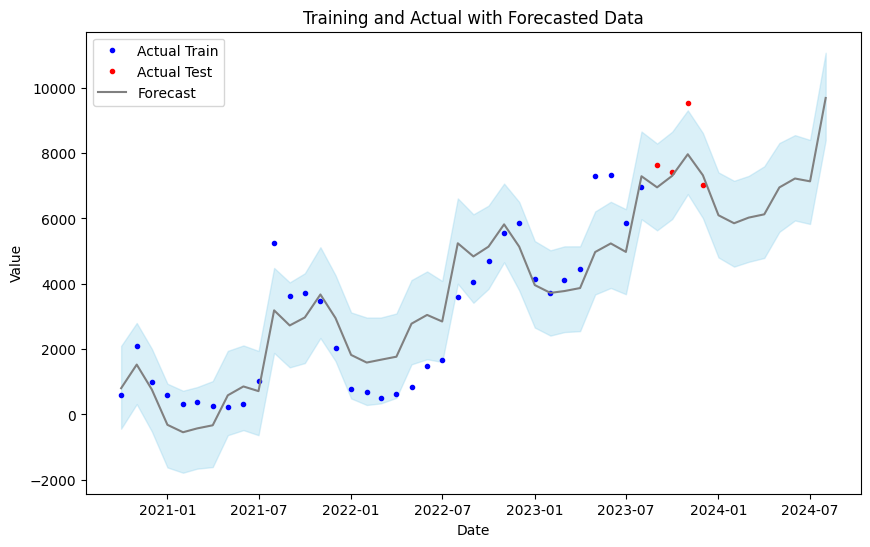

In [22]:
# show results
fig_1 = plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 6))
plt.plot(train["ds"], train["y"], '.', label='Actual Train', color = 'blue')
plt.plot(test["ds"], test["y"], '.', label='Actual Test', color = 'red')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='grey')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='skyblue', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Training and Actual with Forecasted Data')
plt.legend()
plt.show()

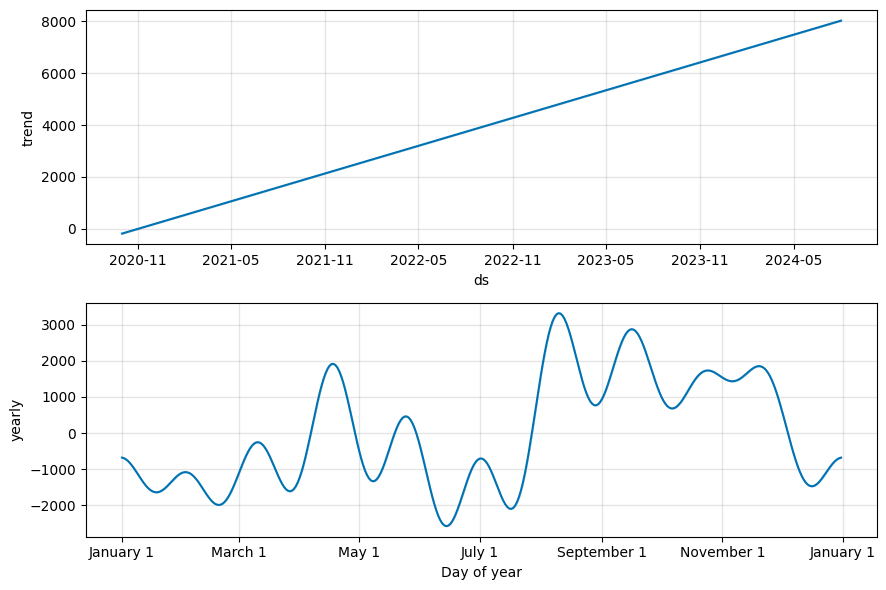

In [23]:
fig_2 = model.plot_components(forecast, plot_cap=20)